In [429]:
import pandas as pd
from datetime import datetime
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from collections import defaultdict
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
import featuretools as ft

trainval = pd.read_csv("C:/Users/Admin/Desktop/Advanced Analytics/Assignment/Assignment 1/data/train.csv")
test = pd.read_csv("C:/Users/Admin/Desktop/Advanced Analytics/Assignment/Assignment 1/data/test.csv")

extra_params = {"feature_tools" : 0, "undersampling" : 1, "oversampling" : 0, "drop_cat_vars" : 0, "time_column" : 1, "corr_thresh" : 0.9}

## Division of Sets

In [430]:
X_trainval = trainval.drop(columns = "target")
y_trainval = trainval["target"]

In [431]:
train, val, train_target, val_target = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42)

In [432]:
train['target'] = train_target
val['target'] = val_target

In [433]:
#Keep average cost min
averagecostmin = val['average cost min']
idtest = test["id"]

## Initial Exploration

In [288]:
train.describe()

,Age,L_O_S,Dropped_Calls,Peak_calls_Sum,Peak_mins_Sum,OffPeak_calls_Sum,OffPeak_mins_Sum,Weekend_calls_Sum,Weekend_mins_Sum,International_mins_Sum,...,call_cost_per_min,actual call cost,Total_call_cost,Total_Cost,average cost min,Peak ratio,OffPeak ratio,Weekend ratio,Nat-InterNat Ratio,target
count,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,...,4032.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000
mean,31.414126,33.699347,2.673358,238.945229,708.792184,104.036431,311.938372,16.322677,50.079971,169.551549,...,10.081397,19.133955,73.501256,186.803427,0.168306,0.609716,0.327824,0.061717,0.162328,0.146716
std,12.775443,14.007828,3.418703,239.288923,503.929355,97.260823,199.167646,16.296733,36.092455,141.787096,...,2.108023,27.987193,60.000356,82.079489,0.077812,0.224430,0.209932,0.063644,0.105643,0.353867
min,12.000000,9.633333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,0.000000,59.940000,0.048998,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,21.300000,0.000000,59.000000,307.500000,28.000000,149.550000,4.000000,22.800000,64.261044,...,8.573250,0.000000,32.134081,123.802373,0.134413,0.466317,0.165139,0.020942,0.078918,0.000000
50%,29.000000,33.666667,1.000000,161.000000,614.400001,73.000000,291.000000,11.000000,44.399999,132.279506,...,9.518597,7.515854,57.801016,173.254831,0.154525,0.654877,0.287722,0.043932,0.157734,0.000000
75%,39.000000,45.933333,2.000000,343.000000,1014.300000,156.000000,446.400000,24.000000,71.750000,236.853610,...,11.696253,28.308661,99.217719,232.116107,0.179302,0.782261,0.458395,0.080924,0.244154,0.000000
max,80.000000,58.200000,15.000000,1626.000000,2901.600001,560.000000,1091.099999,106.000000,205.000000,935.947864,...,21.734694,184.892166,437.063835,587.063835,1.357564,1.000000,1.000000,0.731884,2.601223,1.000000


In [289]:
train.describe(include = 'object')

,Gender,Connect_Date,tariff,Handset,Usage_Band,Tariff_OK,high Dropped calls,No Usage,id
count,4035,4035,4035,4035,4032,4035,4035,4035,4035
unique,2,1310,5,11,5,4,2,2,4035
top,F,11/07/1999,CAT 200,S50,Med,OK,F,F,K277140
freq,2042,11,1802,944,2232,4006,3933,4032,1


Drop ID (too many unique values)

In [290]:
train = train.drop(columns = ["id"])
val = val.drop(columns = ["id"])
test = test.drop(columns = ["id"])

## Preprocessing

#### Feature Engineering

In [291]:
if extra_params["time_column"] == 1:
    train["Connect_Date"] = train["Connect_Date"].apply(lambda x : datetime.strptime(x, "%d/%m/%Y"))
    test["Connect_Date"] = test["Connect_Date"].apply(lambda x : datetime.strptime(x, "%d/%m/%y"))
    val["Connect_Date"] = val["Connect_Date"].apply(lambda x : datetime.strptime(x, "%d/%m/%Y"))
    
    max_train = train["Connect_Date"].max()
    
    train["End_Date"] = max_train
    test["End_Date"] = max_train
    val["End_Date"] = max_train

    train["Connect_Time"] = train["End_Date"] - train["Connect_Date"]
    test["Connect_Time"] = test["End_Date"] - test["Connect_Date"]
    val["Connect_Time"] = val["End_Date"] - val["Connect_Date"]

    train["Connect_Time"] = train["Connect_Time"].apply(lambda x : x.days)
    test["Connect_Time"] = test["Connect_Time"].apply(lambda x : x.days)
    val["Connect_Time"] = val["Connect_Time"].apply(lambda x : x.days)

    train = train.drop(columns = ["End_Date"])
    test = test.drop(columns = ["End_Date"])
    val = val.drop(columns = ["End_Date"])

train = train.drop(columns = ["Connect_Date"])
test = test.drop(columns = ["Connect_Date"])
val = val.drop(columns = ["Connect_Date"])

#### Missing Values

In [292]:
train.isna().sum()

Gender                    0
Age                       0
L_O_S                     0
Dropped_Calls             0
tariff                    0
Handset                   0
Peak_calls_Sum            0
Peak_mins_Sum             0
OffPeak_calls_Sum         0
OffPeak_mins_Sum          0
Weekend_calls_Sum         0
Weekend_mins_Sum          0
International_mins_Sum    0
Nat_call_cost_Sum         0
AvePeak                   0
AveOffPeak                0
AveWeekend                0
National_calls            0
National mins             0
AveNational               0
All_calls_mins            0
Dropped_calls_ratio       3
Usage_Band                3
Mins_charge               0
call_cost_per_min         3
actual call cost          0
Total_call_cost           0
Total_Cost                0
Tariff_OK                 0
average cost min          0
Peak ratio                0
OffPeak ratio             0
Weekend ratio             0
Nat-InterNat Ratio        0
high Dropped calls        0
No Usage            

In [293]:
rows_with_missing_values = train[train.isnull().any(axis=1)]

In [294]:
rows_with_missing_values[["call_cost_per_min", "Dropped_calls_ratio", "Usage_Band"]]

,call_cost_per_min,Dropped_calls_ratio,Usage_Band
3836,NaN,NaN,NaN
4301,NaN,NaN,NaN
3237,NaN,NaN,NaN


Missing values are all in the same 3 rows. Since they're only 3 observations out of 4035, they're imputed using median imputation

##### Imputing Numerical Columns

In [295]:
# Assuming 'data' is your dataset with missing values
# Create an instance of SimpleImputer with strategy='median'
imputer = SimpleImputer(strategy='median')

# Fit the imputer on the data
imputer.fit(train[["call_cost_per_min", "Dropped_calls_ratio"]])

# Transform the data by replacing missing values with the median
test_clean = imputer.transform(test[["call_cost_per_min", "Dropped_calls_ratio"]])
train_clean = imputer.transform(train[["call_cost_per_min", "Dropped_calls_ratio"]])
val_clean = imputer.transform(val[["call_cost_per_min", "Dropped_calls_ratio"]])

In [296]:
train["call_cost_per_min"] = train_clean[:, 0]
test["call_cost_per_min"] = test_clean[:, 0]
val["call_cost_per_min"] = val_clean[:, 0]

train["Dropped_calls_ratio"] = train_clean[:, 1]
test["Dropped_calls_ratio"] = test_clean[:, 1]
val["Dropped_calls_ratio"] = val_clean[:, 1]

##### Imputing Categorical Column

In [297]:
# Initialize the imputer with 'most_frequent' strategy
imputer = SimpleImputer(strategy='most_frequent')

imputer.fit(np.array(train["Usage_Band"]).reshape(-1, 1))

train["Usage_Band"] = imputer.transform(np.array(train["Usage_Band"]).reshape(-1, 1))[:, 0]
test["Usage_Band"] = imputer.transform(np.array(test["Usage_Band"]).reshape(-1, 1))[:, 0]
val["Usage_Band"] = imputer.transform(np.array(val["Usage_Band"]).reshape(-1, 1))[:, 0]

#### Variable Selection

##### Dropping numerical variables that are useless

In [298]:
correlation_matrix = train[train.select_dtypes(include=['number']).columns.tolist()].corr()

In [299]:
corrtarget = correlation_matrix['target']

In [300]:
# Make plot for this

In [301]:
high_correlation_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > extra_params["corr_thresh"]:
            high_correlation_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))


In [302]:
high_correlation_pairs

[('L_O_S', 'Connect_Time'),
 ('Peak_calls_Sum', 'National_calls'),
 ('Peak_mins_Sum', 'National mins'),
 ('Peak_mins_Sum', 'All_calls_mins'),
 ('Peak_mins_Sum', 'Total_Cost'),
 ('International_mins_Sum', 'Total_call_cost'),
 ('International_mins_Sum', 'Total_Cost'),
 ('Nat_call_cost_Sum', 'Mins_charge'),
 ('Nat_call_cost_Sum', 'actual call cost'),
 ('National mins', 'All_calls_mins'),
 ('National mins', 'Total_Cost'),
 ('All_calls_mins', 'Total_call_cost'),
 ('All_calls_mins', 'Total_Cost'),
 ('Mins_charge', 'actual call cost'),
 ('Total_call_cost', 'Total_Cost'),
 ('Peak ratio', 'OffPeak ratio')]

In [303]:
def build_adjacency_list(pairs):
    adjacency_list = defaultdict(list)
    for u, v in pairs:
        adjacency_list[u].append(v)
        adjacency_list[v].append(u)
    return adjacency_list

# Function to perform depth-first search (DFS) traversal to find connected components
def dfs(node, adjacency_list, visited, component):
    visited.add(node)
    component.append(node)
    for neighbor in adjacency_list[node]:
        if neighbor not in visited:
            dfs(neighbor, adjacency_list, visited, component)

# Function to find connected components in the graph
def find_connected_components(pairs):
    adjacency_list = build_adjacency_list(pairs)
    visited = set()
    connected_components = []
    for node in adjacency_list:
        if node not in visited:
            component = []
            dfs(node, adjacency_list, visited, component)
            connected_components.append(component)
    return connected_components

# Find connected groups
connected_groups = find_connected_components(high_correlation_pairs)

In [304]:
def get_variables_to_drop(group, corrtarget):
    max_cor = 0
    var_max = ''
    for var in group:
        if abs(corrtarget[var]) > max_cor:
            var_max = var
            max_cor = abs(corrtarget[var])
    group.remove(var_max)

    return group

In [305]:
variables_to_drop = [get_variables_to_drop(group, corrtarget) for group in connected_groups]

In [306]:
drop_vars = [item for sublist in variables_to_drop for item in sublist]

In [307]:
train = train.drop(columns = drop_vars)

In [308]:
val = val.drop(columns = drop_vars)

In [309]:
test = test.drop(columns = drop_vars)

##### Deleting categorical variables that are useless

In [310]:
for variable in list(train.describe(include = 'object').columns):
    print(train.groupby('target')[variable].value_counts())

target  Gender
0       F         1761
        M         1682
1       M          311
        F          281
Name: count, dtype: int64
target  tariff  
0       CAT 200     1533
        CAT 100      736
        Play 100     503
        Play 300     471
        CAT 50       200
1       CAT 200      269
        Play 100     128
        CAT 100      110
        Play 300      47
        CAT 50        38
Name: count, dtype: int64
target  Handset
0       S50        825
        BS110      599
        S80        574
        WC95       526
        ASAD170    514
        BS210      220
        CAS60       90
        ASAD90      42
        CAS30       37
        SOP20       10
        SOP10        6
1       ASAD90     174
        S50        119
        CAS30      108
        BS110       95
        SOP10       28
        SOP20       24
        S80         20
        ASAD170     10
        BS210        8
        WC95         6
Name: count, dtype: int64
target  Usage_Band
0       Med           1974
   

In [311]:
#Make plots for this

UsageBand, Tariff seem useless
Most useful inferences: High Dropped Calls seems a good indicator for whether someone will churn or not, ratio of Trues for churners is much higher. Tariff_Ok's High Cat 100 for churners is much higher than for non churners, would be good to add numerical encoding. Same for handset, numerical encoding would be nice. 

In [312]:
if extra_params["drop_cat_vars"] == 1:
    train = train.drop(columns = ["No Usage", "Usage_Band", "tariff"])
    test = test.drop(columns = ["No Usage", "Usage_Band", "tariff"])
    val = val.drop(columns = ["No Usage", "Usage_Band", "tariff"])

Outliers are not dealth with (they are useful in our detection, the higher the costs the bigger the probability of churning?)

#### Variable Transformation

##### Numerical Variables

In [313]:
test['target'] = 0

In [314]:
# List of numerical variable names
numerical_features = train.select_dtypes(include=['number']).columns.tolist()

# List of categorical variable names (replace with actual categorical variable names)
categorical_features = train.select_dtypes(exclude=['number']).columns.tolist()

# Define the transformers
transformers = [
    ('num', MinMaxScaler(), numerical_features)
]

# Create the column transformer
preprocessor = ColumnTransformer(transformers, remainder='passthrough')

# Apply the column transformer to the data
transformed_train = preprocessor.fit_transform(train)
transformed_val = preprocessor.transform(val)
transformed_test = preprocessor.transform(test)


# Convert the transformed data back to DataFrame
transformed_train = pd.DataFrame(transformed_train, columns=numerical_features + categorical_features)
transformed_test = pd.DataFrame(transformed_test, columns=numerical_features + categorical_features)
transformed_val = pd.DataFrame(transformed_val, columns=numerical_features + categorical_features)



# Only the numerical variables will be scaled to the range [0, 1]

MinMaxScaling (0, 1)

MinMaxScaling (-1, 1)

Normalization + MinMaxScaling

##### Categorical Variables

One-Hot Encoding

In [315]:
for variable in list(train.describe(include = 'object').columns):
    print(train.groupby('target')[variable].value_counts())

target  Gender
0       F         1761
        M         1682
1       M          311
        F          281
Name: count, dtype: int64
target  tariff  
0       CAT 200     1533
        CAT 100      736
        Play 100     503
        Play 300     471
        CAT 50       200
1       CAT 200      269
        Play 100     128
        CAT 100      110
        Play 300      47
        CAT 50        38
Name: count, dtype: int64
target  Handset
0       S50        825
        BS110      599
        S80        574
        WC95       526
        ASAD170    514
        BS210      220
        CAS60       90
        ASAD90      42
        CAS30       37
        SOP20       10
        SOP10        6
1       ASAD90     174
        S50        119
        CAS30      108
        BS110       95
        SOP10       28
        SOP20       24
        S80         20
        ASAD170     10
        BS210        8
        WC95         6
Name: count, dtype: int64
target  Usage_Band
0       Med           1974
   

In [316]:
# Encode binary variables using map
binary_mapping1 = {'M': 1, 'F': 0}
binary_mapping2 = {'T': 1, 'F': 0}

transformed_train['high Dropped calls'] = transformed_train['high Dropped calls'].map(binary_mapping2)
transformed_train['No Usage'] = transformed_train['No Usage'].map(binary_mapping2)
transformed_train['Gender'] = transformed_train['Gender'].map(binary_mapping1)
transformed_test['high Dropped calls'] = transformed_test['high Dropped calls'].map(binary_mapping2)
transformed_test['No Usage'] = transformed_test['No Usage'].map(binary_mapping2)
transformed_test['Gender'] = transformed_test['Gender'].map(binary_mapping1)
transformed_val['high Dropped calls'] = transformed_val['high Dropped calls'].map(binary_mapping2)
transformed_val['No Usage'] = transformed_val['No Usage'].map(binary_mapping2)
transformed_val['Gender'] = transformed_val['Gender'].map(binary_mapping1)


# Filter and encode categorical variables
# For categorical_1, keep only 'High CAT 100', encode the rest as 'Other'
transformed_train['Tariff_OK'] = transformed_train['Tariff_OK'].apply(lambda x: 1 if x == 'High CAT 100' else 0)
transformed_test['Tariff_OK'] = transformed_test['Tariff_OK'].apply(lambda x: 1 if x == 'High CAT 100' else 0)
transformed_val['Tariff_OK'] = transformed_val['Tariff_OK'].apply(lambda x: 1 if x == 'High CAT 100' else 0)

# Encode categorical_2 using one-hot encoding
encoded_train = pd.get_dummies(transformed_train, columns=['Handset', "tariff", "Usage_Band"], dtype = int)
encoded_test = pd.get_dummies(transformed_test, columns=['Handset', "tariff", "Usage_Band"], dtype = int)
encoded_val = pd.get_dummies(transformed_val, columns=['Handset', "tariff", "Usage_Band"], dtype = int)

In [317]:
encoded_val['target'] = encoded_val['target'].astype('category')

In [318]:
X_train = encoded_train.drop(columns = "target")
y_train = encoded_train["target"]

In [319]:
X_val = encoded_val.drop(columns = "target")
y_val = encoded_val["target"]

In [320]:
X_test = encoded_test.drop(columns = "target")

In [321]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the categorical labels
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)

#### Oversampling / Undersampling

##### Oversampling

In [322]:
if extra_params.get("oversampling") == 1:
    if X_train is not None and y_train is not None:
        # Ensure y_train is an array of integers
        print("y_train data type:", type(y_train))

        # Apply SMOTE for oversampling
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

        # Update X_train and y_train with resampled data
        X_train = X_resampled
        y_train = y_resampled
    else:
        print("X_train or y_train is None. Please check the input data.")
else:
    print("Oversampling is disabled.")

Oversampling is disabled.


##### Undersampling

In [323]:
# Apply RandomUnderSampler for undersampling
if extra_params["undersampling"] == 1:
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

    X_train = X_resampled
    y_train = y_resampled

## Creation of Scoring Function

In [443]:
# Develop the evaluation metric - Profit top k
from sklearn.metrics import make_scorer

def Profit_top_k(estimator, X_train, y_train):
    k = 20
    var = 'average cost min'
    
    estimator.fit(X_train, y_train)
    
    y_pred = estimator.predict(X_train)
    
    y_pred_proba = estimator.predict_proba(X_train)
    y_pred_proba = [sublist[1] for sublist in y_pred_proba]

    averagecostmin = X_train['average cost min']
    
    df_results = pd.DataFrame()
    df_results['y_pred'] = y_pred
    df_results['y_true'] = y_train
    df_results['predict_proba'] = y_pred_proba
    df_results['average cost min'] = list(averagecostmin)
    
    sorted_df = df_results.sort_values(by= "predict_proba", ascending = False)
    #print (sorted_df)
    #print (sorted_df['average cost min'].iloc[0])
    sum = 0
    for i in range(0, k):
        if sorted_df['y_true'][i] == sorted_df['y_pred'][i]:
            
            sum += sorted_df['average cost min'].iloc[i]
            #print (sum)
            
    return sum

# Make the scorer
Profit_top_k_scorer = make_scorer(Profit_top_k, response_method=("predict_proba","predict"), greater_is_better=False, k=X_train)

In [498]:
# Develop the evaluation metric - AUC

def AUC(estimator, X_train, y_train):
    
    y_pred = estimator.predict(X_train)
    fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred)
    AUC = metrics.auc(fpr, tpr)
    
    return AUC

In [499]:
# Develop the evaluation metric - Combination

def model_score(estimator, X_train, y_train):
    
    Profit_top_k_score = Profit_top_k(estimator, X_train, y_train)
    AUC_score = AUC(estimator, X_train, y_train)
    model_score = 0.7*Profit_top_k_score + 0.3*AUC_score

    return model_score

## Single Model

### 1. random forest

#### fitting and cross validation

In [500]:
# Fitting the model

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold

random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)

RandomForestClassifier()

#### hyperparameters

In [501]:
# Suppress warnings
warnings.filterwarnings("ignore")

# Create KFold cross-validation object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': np.arange(1, 11),
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 11),
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Create a Random Forest classifier instance
rf = RandomForestClassifier()

# Create RandomizedSearchCV with custom scoring
rf_cv = RandomizedSearchCV(rf, param_grid, cv=kf, n_iter=10, scoring=model_score)

# Fit the model
rf_cv.fit(X_train, y_train)

# Print the best parameters and best score
print(rf_cv.best_params_, rf_cv.best_score_)

# Create a Random Forest model with the best parameters
best_rf = RandomForestClassifier(**rf_cv.best_params_)

# Fit the model to the training data
best_rf.fit(X_train, y_train)


{'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10} 2.0797380352065096


RandomForestClassifier(max_depth=10, max_features='log2', min_samples_leaf=2,
                       min_samples_split=4, n_estimators=200)

In [502]:
print (model_score(random_forest, X_train, y_train),  model_score(best_rf, X_train, y_train))## not improded

1.6672180081096406 1.6621889532748684


In [503]:
# Cross validation
random_forest_cv = cross_val_score(random_forest, X_train, y_train, cv=5, scoring=model_score)

In [504]:
random_forest_cv

array([1.59209738, 1.44878569, 1.67341685, 2.85869861, 1.65200708])

#### gap analysis

In [506]:
y_pred_proba = random_forest.predict_proba(X_val)
y_pred_proba = [sublist[1] for sublist in y_pred_proba]

df_results_val = pd.DataFrame()
df_results_val['y_pred'] = y_pred
df_results_val['y_true'] = y_val
df_results_val['predict_proba'] = y_pred_proba
df_results_val['average cost min'] = list(averagecostmin)

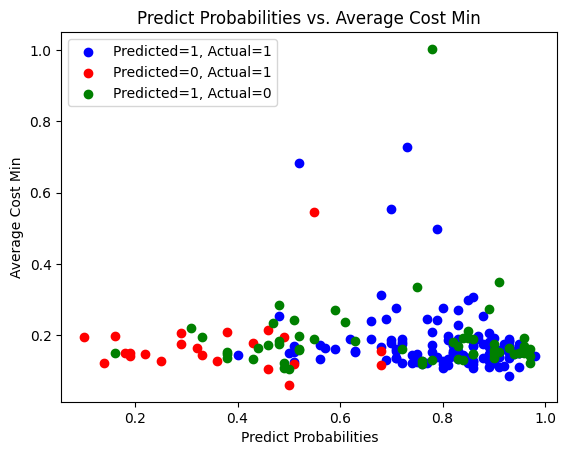

In [507]:
# Scatter plot for predicted target = 1 and actual target = 1
plt.scatter(df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 1), 'predict_proba'],
            df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 1), 'average cost min'],
            color='blue', label='Predicted=1, Actual=1')

# Scatter plot for predicted target = 0 and actual target = 1
plt.scatter(df_results_val.loc[(df_results_val['y_pred'] == 0) & (df_results_val['y_true'] == 1), 'predict_proba'],
            df_results_val.loc[(df_results_val['y_pred'] == 0) & (df_results_val['y_true'] == 1), 'average cost min'],
            color='red', label='Predicted=0, Actual=1')

# Scatter plot for predicted target = 1 and actual target = 0
plt.scatter(df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 0), 'predict_proba'],
            df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 0), 'average cost min'],
            color='green', label='Predicted=1, Actual=0')

# Set labels and title
plt.xlabel('Predict Probabilities')
plt.ylabel('Average Cost Min')
plt.title('Predict Probabilities vs. Average Cost Min')

# Add legend
plt.legend()

# Show plot
plt.show()

This plot shows that only one churning point with high Average Cost Min is not identified by the model, the other 4 in that area are. The issue is that since there are many many more observations with a low average cost min, the top 20 predicted by the model are more likely to be all of low average cost min.

In [508]:
#sort_results

NameError: name 'sort_results' is not defined

In [509]:
#sum(sort_results["average cost min"][:20])

NameError: name 'sort_results' is not defined

#### Test Predictions

In [512]:
y_pred_proba_test = random_forest.predict_proba(X_test)
y_pred_proba_test = [sublist[1] for sublist in y_pred_proba_test]

In [513]:
df_results = pd.DataFrame()
df_results["ID"] = idtest
df_results["PRED"] = y_pred_proba_test

In [514]:
df_results.to_csv("Model_Results_random_forest.csv", index = False)

### 2. KNN

#### fitting and cross validation

In [515]:
# import necessary functions
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from sklearn.preprocessing import StandardScaler

In [516]:
# fit the model
knn = KNeighborsClassifier(n_neighbors=10, weights='distance')
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10, weights='distance')

### hyper param

In [517]:
# Create KFold cross-validation object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter grid
param_grid = {
    'n_neighbors': np.arange(1, 21),  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithm used to compute the nearest neighbors
    'p': [1, 2],  # Power parameter for the Minkowski metric (1 for Manhattan distance, 2 for Euclidean distance)
}

# Create a KNN classifier instance
knn = KNeighborsClassifier()

# Create RandomizedSearchCV with custom scoring
knn_cv = RandomizedSearchCV(knn, param_grid, cv=kf, n_iter=10, scoring=model_score)

# Fit the model
knn_cv.fit(X_train, y_train)

# Print the best parameters and best score
print(knn_cv.best_params_, knn_cv.best_score_)

{'weights': 'uniform', 'p': 1, 'n_neighbors': 3, 'algorithm': 'kd_tree'} 1.6850387462837912


In [518]:
knn = KNeighborsClassifier(weights='uniform', p=1, n_neighbors=3, algorithm='brute')
knn_cv.fit(X_train, y_train)


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=KNeighborsClassifier(),
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20]),
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']},
                   scoring=<function model_score at 0x00000251194EBEC0>)

In [519]:
model_score(knn, X_train, y_train)#1.5526297867148593

1.5335852698524413

In [520]:
# cross validation
knn_cv = cross_val_score(knn, X_train, y_train, cv=5, scoring=model_score)
knn_cv

array([1.49643142, 1.58537879, 1.58922084, 1.92817096, 1.58312813])

#### gap analysis

In [521]:
y_pred_proba = knn.predict_proba(X_val)
y_pred_proba = [sublist[1] for sublist in y_pred_proba]

df_results_val = pd.DataFrame()
df_results_val['y_pred'] = y_pred
df_results_val['y_true'] = y_val
df_results_val['predict_proba'] = y_pred_proba
df_results_val['average cost min'] = list(averagecostmin)

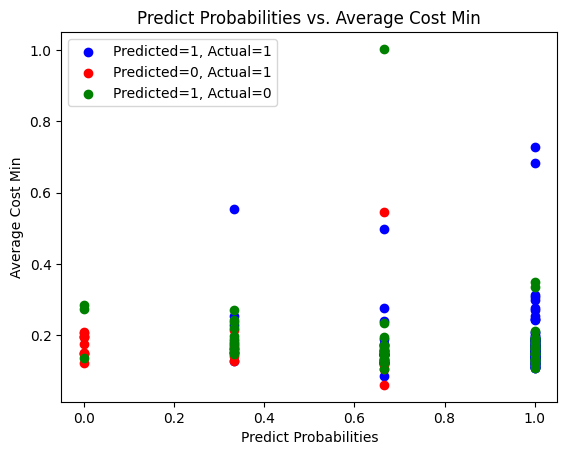

In [522]:
# Scatter plot for predicted target = 1 and actual target = 1
plt.scatter(df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 1), 'predict_proba'],
            df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 1), 'average cost min'],
            color='blue', label='Predicted=1, Actual=1')

# Scatter plot for predicted target = 0 and actual target = 1
plt.scatter(df_results_val.loc[(df_results_val['y_pred'] == 0) & (df_results_val['y_true'] == 1), 'predict_proba'],
            df_results_val.loc[(df_results_val['y_pred'] == 0) & (df_results_val['y_true'] == 1), 'average cost min'],
            color='red', label='Predicted=0, Actual=1')

# Scatter plot for predicted target = 1 and actual target = 0
plt.scatter(df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 0), 'predict_proba'],
            df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 0), 'average cost min'],
            color='green', label='Predicted=1, Actual=0')

# Set labels and title
plt.xlabel('Predict Probabilities')
plt.ylabel('Average Cost Min')
plt.title('Predict Probabilities vs. Average Cost Min')

# Add legend
plt.legend()

# Show plot
plt.show()

#### Test Predictions

In [523]:
y_pred_proba_test = knn.predict_proba(X_test)
y_pred_proba_test = [sublist[1] for sublist in y_pred_proba_test]

In [524]:
df_results = pd.DataFrame()
df_results["ID"] = idtest
df_results["PRED"] = y_pred_proba_test

In [525]:
df_results.to_csv("Model_Results_knn.csv", index = False)

### 3. Decision tree

#### fitting and cross validation

In [526]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, make_scorer

decision_tree = DecisionTreeClassifier()

decision_tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [527]:
warnings.filterwarnings("ignore")

# Create KFold cross-validation object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter grid
param_grid = {
    'max_depth': np.arange(1, 11),
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 11),
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Create a Decision Tree classifier instance
dt = DecisionTreeClassifier()

# Create RandomizedSearchCV with custom scoring
dt_cv = RandomizedSearchCV(dt, param_grid, cv=kf, n_iter=10, scoring=model_score)

# Fit the model
dt_cv.fit(X_train, y_train)

# Print the best parameters and best score
print(dt_cv.best_params_, dt_cv.best_score_)

# Create a Decision Tree model with the best parameters
best_dt = DecisionTreeClassifier(**dt_cv.best_params_)

# Fit the model to the training data
best_dt.fit(X_train, y_train)


{'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 4} 1.5314806215774195


DecisionTreeClassifier(max_depth=4, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=4)

In [528]:
print (model_score(decision_tree, X_train, y_train),  model_score(best_dt, X_train, y_train))## not improded

1.5665429179728037 0.4992484717436305


In [529]:
model_score(decision_tree, X_train, y_train)

1.5665429179728037

In [530]:
# Cross validation
decision_tree_cv = cross_val_score(decision_tree, X_train, y_train, cv=5, scoring=model_score)

In [531]:
decision_tree_cv

array([1.49413495, 1.74637741, 1.69165766, 1.69337588, 1.59721886])

#### gap analysis

In [532]:
y_pred_proba = decision_tree.predict_proba(X_val)
y_pred_proba = [sublist[1] for sublist in y_pred_proba]

df_results_val = pd.DataFrame()
df_results_val['y_pred'] = y_pred
df_results_val['y_true'] = y_val
df_results_val['predict_proba'] = y_pred_proba
df_results_val['average cost min'] = list(averagecostmin)

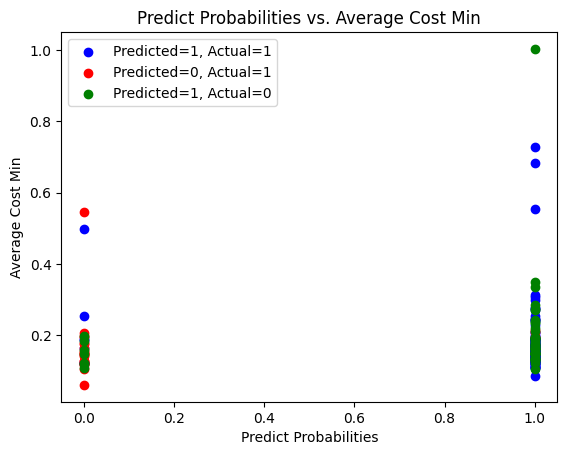

In [533]:
# Scatter plot for predicted target = 1 and actual target = 1
plt.scatter(df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 1), 'predict_proba'],
            df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 1), 'average cost min'],
            color='blue', label='Predicted=1, Actual=1')

# Scatter plot for predicted target = 0 and actual target = 1
plt.scatter(df_results_val.loc[(df_results_val['y_pred'] == 0) & (df_results_val['y_true'] == 1), 'predict_proba'],
            df_results_val.loc[(df_results_val['y_pred'] == 0) & (df_results_val['y_true'] == 1), 'average cost min'],
            color='red', label='Predicted=0, Actual=1')

# Scatter plot for predicted target = 1 and actual target = 0
plt.scatter(df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 0), 'predict_proba'],
            df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 0), 'average cost min'],
            color='green', label='Predicted=1, Actual=0')

# Set labels and title
plt.xlabel('Predict Probabilities')
plt.ylabel('Average Cost Min')
plt.title('Predict Probabilities vs. Average Cost Min')

# Add legend
plt.legend()

# Show plot
plt.show()

#### test prediction

In [534]:
y_pred_proba_test = decision_tree.predict_proba(X_test)
y_pred_proba_test = [sublist[1] for sublist in y_pred_proba_test]

In [535]:
df_results = pd.DataFrame()
df_results["ID"] = idtest
df_results["PRED"] = y_pred_proba_test

In [536]:
df_results.to_csv("Model_Results_decision_tree.csv", index = False)

### 4.Logistic regression

#### fitting and cross validation

In [537]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

logreg.fit(X_train, y_train)

LogisticRegression()

#### hyper param

In [538]:
# Create KFold cross-validation object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter grid
param_grid = {
    'penalty': ['l1', 'l2'],  # Regularization penalty (L1 or L2)
    'C': np.logspace(-4, 4, 20),  # Inverse of regularization strength
    'solver': ['liblinear', 'saga'],  # Algorithm to use in the optimization problem
    'max_iter': [100, 200, 300, 400, 500]  # Maximum number of iterations
}

# Create a logistic regression classifier instance
logistic_reg = LogisticRegression()

# Create RandomizedSearchCV with custom scoring
logistic_cv = RandomizedSearchCV(logistic_reg, param_grid, cv=kf, n_iter=10, scoring=model_score)

# Fit the model
logistic_cv.fit(X_train, y_train)

# Print the best parameters and best score
print(logistic_cv.best_params_, logistic_cv.best_score_)

# Create a logistic regression model with the best parameters
best_logistic_reg = LogisticRegression(**logistic_cv.best_params_)

# Fit the model to the training data
best_logistic_reg.fit(X_train, y_train)

# Now you can use the best_logistic_reg model for prediction

{'solver': 'saga', 'penalty': 'l2', 'max_iter': 300, 'C': 78.47599703514607} 1.7871541918872442


LogisticRegression(C=78.47599703514607, max_iter=300, solver='saga')

In [539]:
print (model_score(logreg, X_train, y_train),  model_score(best_logistic_reg, X_train, y_train))## not improded

1.8344115428644785 1.7583718436565035


In [540]:
# Cross validation
logreg_cv = cross_val_score(random_forest, X_train, y_train, cv=5, scoring=model_score)

#### gap analysis

In [541]:
y_pred_proba = logreg.predict_proba(X_val)
y_pred_proba = [sublist[1] for sublist in y_pred_proba]

df_results_val = pd.DataFrame()
df_results_val['y_pred'] = y_pred
df_results_val['y_true'] = y_val
df_results_val['predict_proba'] = y_pred_proba
df_results_val['average cost min'] = list(averagecostmin)

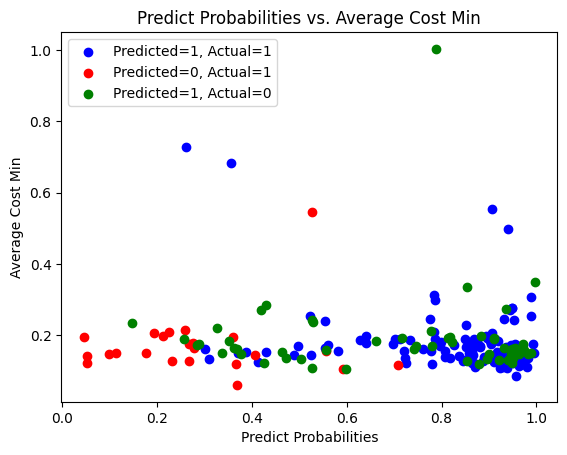

In [542]:
# Scatter plot for predicted target = 1 and actual target = 1
plt.scatter(df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 1), 'predict_proba'],
            df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 1), 'average cost min'],
            color='blue', label='Predicted=1, Actual=1')

# Scatter plot for predicted target = 0 and actual target = 1
plt.scatter(df_results_val.loc[(df_results_val['y_pred'] == 0) & (df_results_val['y_true'] == 1), 'predict_proba'],
            df_results_val.loc[(df_results_val['y_pred'] == 0) & (df_results_val['y_true'] == 1), 'average cost min'],
            color='red', label='Predicted=0, Actual=1')

# Scatter plot for predicted target = 1 and actual target = 0
plt.scatter(df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 0), 'predict_proba'],
            df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 0), 'average cost min'],
            color='green', label='Predicted=1, Actual=0')

# Set labels and title
plt.xlabel('Predict Probabilities')
plt.ylabel('Average Cost Min')
plt.title('Predict Probabilities vs. Average Cost Min')

# Add legend
plt.legend()

# Show plot
plt.show()

#### test prediction

In [543]:
y_pred_proba_test = logreg.predict_proba(X_test)
y_pred_proba_test = [sublist[1] for sublist in y_pred_proba_test]

In [544]:
df_results = pd.DataFrame()
df_results["ID"] = idtest
df_results["PRED"] = y_pred_proba_test

In [545]:
df_results.to_csv("Model_Results_logreg.csv", index = False)

### 5. Neural Networks

#### fitting and cross validation

In [546]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(100,), )

mlp.fit(X_train, y_train)

MLPClassifier()

#### hyper param

In [547]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.neural_network import MLPClassifier
import warnings

warnings.filterwarnings("ignore")

# Create KFold cross-validation object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(100,), (50, 50), (100, 50, 25)],  # Sizes of hidden layers
    'activation': ['logistic', 'tanh', 'relu'],  # Activation function for hidden layers
    'solver': ['adam', 'sgd'],  # Solver for weight optimization
    'alpha': np.logspace(-4, 4, 20),  # L2 penalty (regularization term) parameter
    'learning_rate': ['constant', 'invscaling', 'adaptive'],  # Learning rate schedule for weight updates
}

# Create a neural network classifier instan

# Create RandomizedSearchCV with custom scoring
mlp_cv = RandomizedSearchCV(mlp, param_grid, cv=kf, n_iter=10, scoring=model_score)

# Fit the model
mlp_cv.fit(X_train, y_train)

# Print the best parameters and best score
print(mlp_cv.best_params_, mlp_cv.best_score_)

# Create a neural network model with the best parameters
best_mlp = MLPClassifier(**mlp_cv.best_params_)

# Fit the model to the training data
best_mlp.fit(X_train, y_train)

# Now you can use the best_mlp model for prediction

{'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (100, 50, 25), 'alpha': 0.0006951927961775605, 'activation': 'logistic'} 2.0544482442516


MLPClassifier(activation='logistic', alpha=0.0006951927961775605,
              hidden_layer_sizes=(100, 50, 25))

In [548]:
print (model_score(mlp, X_train, y_train),  model_score(best_mlp, X_train, y_train))

1.8921704394042482 1.408824743490615


In [549]:
# Cross validation
mlp_cv = cross_val_score(best_mlp, X_train, y_train, cv=5, scoring=model_score)
mlp_cv

array([2.51483593, 0.15      , 0.15      , 2.5903552 , 1.99780502])

#### gap analysis

In [550]:
y_pred_proba = best_mlp.predict_proba(X_val)
y_pred_proba = [sublist[1] for sublist in y_pred_proba]

df_results_val = pd.DataFrame()
df_results_val['y_pred'] = y_pred
df_results_val['y_true'] = y_val
df_results_val['predict_proba'] = y_pred_proba
df_results_val['average cost min'] = list(averagecostmin)

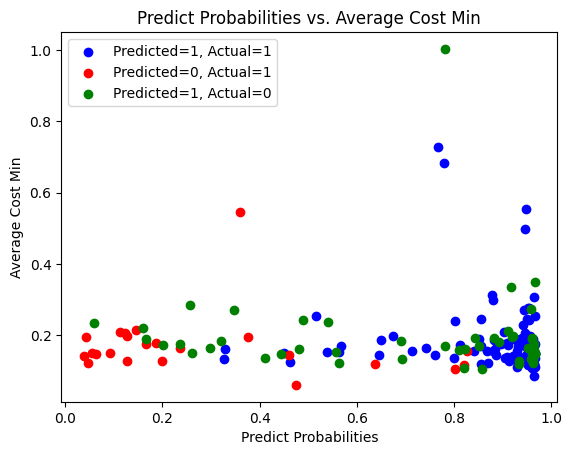

In [551]:
# Scatter plot for predicted target = 1 and actual target = 1
plt.scatter(df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 1), 'predict_proba'],
            df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 1), 'average cost min'],
            color='blue', label='Predicted=1, Actual=1')

# Scatter plot for predicted target = 0 and actual target = 1
plt.scatter(df_results_val.loc[(df_results_val['y_pred'] == 0) & (df_results_val['y_true'] == 1), 'predict_proba'],
            df_results_val.loc[(df_results_val['y_pred'] == 0) & (df_results_val['y_true'] == 1), 'average cost min'],
            color='red', label='Predicted=0, Actual=1')

# Scatter plot for predicted target = 1 and actual target = 0
plt.scatter(df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 0), 'predict_proba'],
            df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 0), 'average cost min'],
            color='green', label='Predicted=1, Actual=0')

# Set labels and title
plt.xlabel('Predict Probabilities')
plt.ylabel('Average Cost Min')
plt.title('Predict Probabilities vs. Average Cost Min')

# Add legend
plt.legend()

# Show plot
plt.show()

#### test prediction

In [552]:
y_pred_proba_test = mlp.predict_proba(X_test)
y_pred_proba_test = [sublist[1] for sublist in y_pred_proba_test]

In [553]:
df_results = pd.DataFrame()
df_results["ID"] = idtest
df_results["PRED"] = y_pred_proba_test

In [554]:
df_results.to_csv("Model_Results_mlp.csv", index = False)

## Ensemble models

### 1. Bagging

#### fitting and cross validation

In [555]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', DecisionTreeClassifier(random_state=42))])

In [556]:
model_score(pipeline, X_train, y_train)

1.5665429179728037

In [557]:
# Cross validation
pipeline_cv = cross_val_score(pipeline, X_train, y_train, cv=5, scoring=model_score)
pipeline_cv

array([1.49413495, 1.74637741, 1.69165766, 1.69337588, 1.59721886])

#### gap analysis

In [558]:
y_pred_proba = pipeline.predict_proba(X_val)
y_pred_proba = [sublist[1] for sublist in y_pred_proba]

df_results_val = pd.DataFrame()
df_results_val['y_pred'] = y_pred
df_results_val['y_true'] = y_val
df_results_val['predict_proba'] = y_pred_proba
df_results_val['average cost min'] = list(averagecostmin)

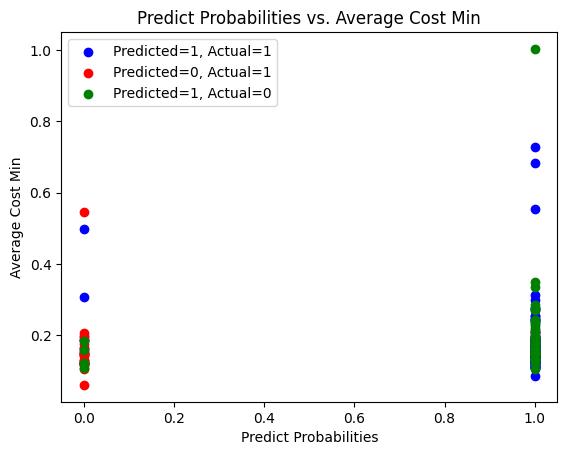

In [559]:
# Scatter plot for predicted target = 1 and actual target = 1
plt.scatter(df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 1), 'predict_proba'],
            df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 1), 'average cost min'],
            color='blue', label='Predicted=1, Actual=1')

# Scatter plot for predicted target = 0 and actual target = 1
plt.scatter(df_results_val.loc[(df_results_val['y_pred'] == 0) & (df_results_val['y_true'] == 1), 'predict_proba'],
            df_results_val.loc[(df_results_val['y_pred'] == 0) & (df_results_val['y_true'] == 1), 'average cost min'],
            color='red', label='Predicted=0, Actual=1')

# Scatter plot for predicted target = 1 and actual target = 0
plt.scatter(df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 0), 'predict_proba'],
            df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 0), 'average cost min'],
            color='green', label='Predicted=1, Actual=0')

# Set labels and title
plt.xlabel('Predict Probabilities')
plt.ylabel('Average Cost Min')
plt.title('Predict Probabilities vs. Average Cost Min')

# Add legend
plt.legend()

# Show plot
plt.show()

#### test prediction

In [560]:
y_pred_proba_test = pipeline.predict_proba(X_test)
y_pred_proba_test = [sublist[1] for sublist in y_pred_proba_test]

In [561]:
df_results = pd.DataFrame()
df_results["ID"] = idtest
df_results["PRED"] = y_pred_proba_test

In [562]:
df_results.to_csv("Model_Results_pipeline.csv", index = False)

### 2. Boosting - Gradient Boosting

#### fitting and cross validation

In [563]:
# install necessary functions
import xgboost as xgb
from xgboost import XGBClassifier

In [564]:
cats1 = X_train.select_dtypes(exclude=np.number).columns.tolist()
cats2 = X_val.select_dtypes(exclude=np.number).columns.tolist()
cats3 = X_test.select_dtypes(exclude=np.number).columns.tolist()
for col in cats1:
    X_train[col] = X_train[col].astype('float')
for col in cats2:
    X_val[col] = X_val[col].astype('float')
for col in cats3:
    X_test[col] = X_test[col].astype('float')

In [565]:
# fitting the model
gradient_boosting = XGBClassifier()
gradient_boosting.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [566]:
model_score(gradient_boosting, X_train, y_train)

1.5585504284843104

In [567]:
# Cross validation
gradient_boosting_cv = cross_val_score(gradient_boosting, X_train, y_train, cv=5, scoring=model_score)
gradient_boosting_cv

array([1.53983513, 1.56616258, 1.83915897, 2.07355005, 1.97471622])

#### gap analysis

In [568]:
y_pred_proba = gradient_boosting.predict_proba(X_val)
y_pred_proba = [sublist[1] for sublist in y_pred_proba]

df_results_val = pd.DataFrame()
df_results_val['y_pred'] = y_pred
df_results_val['y_true'] = y_val
df_results_val['predict_proba'] = y_pred_proba
df_results_val['average cost min'] = list(averagecostmin)

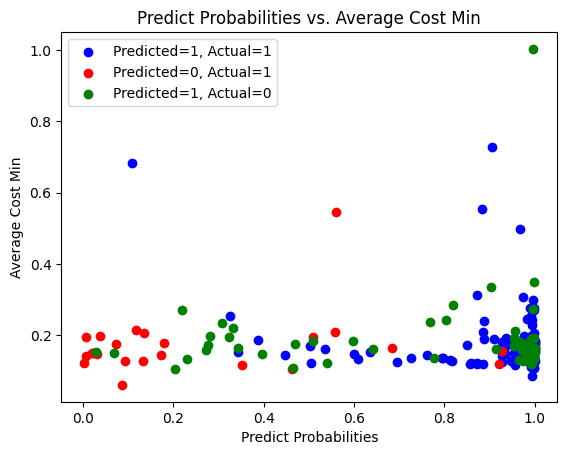

In [569]:
# Scatter plot for predicted target = 1 and actual target = 1
plt.scatter(df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 1), 'predict_proba'],
            df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 1), 'average cost min'],
            color='blue', label='Predicted=1, Actual=1')

# Scatter plot for predicted target = 0 and actual target = 1
plt.scatter(df_results_val.loc[(df_results_val['y_pred'] == 0) & (df_results_val['y_true'] == 1), 'predict_proba'],
            df_results_val.loc[(df_results_val['y_pred'] == 0) & (df_results_val['y_true'] == 1), 'average cost min'],
            color='red', label='Predicted=0, Actual=1')

# Scatter plot for predicted target = 1 and actual target = 0
plt.scatter(df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 0), 'predict_proba'],
            df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 0), 'average cost min'],
            color='green', label='Predicted=1, Actual=0')

# Set labels and title
plt.xlabel('Predict Probabilities')
plt.ylabel('Average Cost Min')
plt.title('Predict Probabilities vs. Average Cost Min')

# Add legend
plt.legend()

# Show plot
plt.show()

#### test prediction

In [570]:
y_pred_proba_test = gradient_boosting.predict_proba(X_test)
y_pred_proba_test = [sublist[1] for sublist in y_pred_proba_test]

In [571]:
#to make it a CSV
df_results = pd.DataFrame()
df_results["ID"] = idtest
df_results["PRED"] = y_pred_proba_test
df_results.to_csv("Model_Results_Gradient_Boosting.csv", index = False)

### Boxplot

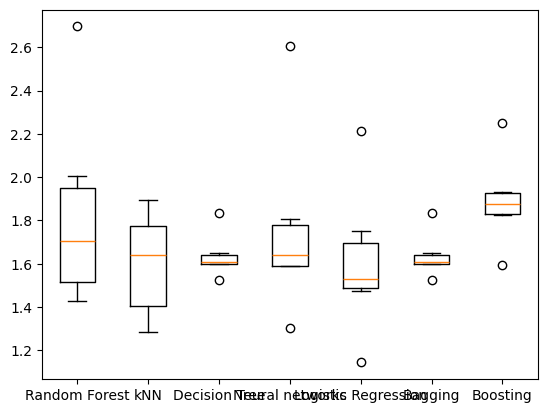

In [572]:
import matplotlib.pyplot as plt

models = {"Random Forest": random_forest, "kNN": knn, "Decision Tree": decision_tree, "Neural networks": mlp,
          "Logistic Regression": logreg, "Bagging": pipeline, "Boosting": gradient_boosting}

classifiers = [('Random Forest', random_forest), ('kNN', knn), ('Decision Tree', decision_tree), 
               ('Neural networks', mlp), ('Logistic Regression', logreg), ('Bagging', pipeline), ('Boosting', gradient_boosting)]

results = []
profit = []

for model in models.values():
    kf = KFold(n_splits=6, random_state=42, shuffle=True)
    
    
    cv_results_N = cross_val_score(model, X_train, y_train, cv=kf, scoring = model_score)
    
    
    results.append(cv_results_N)

plt.boxplot(results, labels=models.keys())
plt.show()

## Voting 

In [573]:
## just take 6 best models make the voting 
# Import VotingClassifier from sklearn.ensemble
from sklearn.ensemble import VotingClassifier


classifiers = [ ('Random forest', random_forest),('Knn', knn),('decision three', decision_tree),('Logistic Regression', logreg),
               ('K Nearest Neighbours', knn), ('mlp', best_mlp), ('gradient boosting', gradient_boosting), ('bagging', pipeline)] 

# Instantiate a VotingClassifier vc with 'soft' voting
vc = VotingClassifier(estimators=classifiers, voting='soft')

# Fit vc to the training set
vc.fit(X_train, y_train)

# Evaluate the test set predictions
y_pred_proba = vc.predict_proba(X_val)  # Probability estimates for each class
y_pred = vc.predict(X_val)  # Predicted class labels
# Calculate accuracy score using custom scoring function
accuracy = model_score(vc, X_val, y_val)
print('Voting Classifier Accuracy: {:.3f}'.format(accuracy))

Voting Classifier Accuracy: 1.676


In [574]:
y_pred_proba_test = vc.predict_proba(X_test)
y_pred_proba_test = [sublist[1] for sublist in y_pred_proba_test]

In [576]:
#to make it a CSV
df_results = pd.DataFrame()
df_results["ID"] = idtest
df_results["PRED"] = y_pred_proba_test
df_results.to_csv("Model_Results_Voting.csv", index = False)